# IMF 외환위기 트라우마 분석  - 개요

본 주피터 노트북에선 IMF 외환위기 당시 퇴직자이냐 아니냐가 추후의 소비 및 투자 성향에 어떠한 영향을 미치는지 알아본다.

실험은 아래와 같은 네 단계 절차로 진행 된다:
1. IMF 당시 정년이었던 사람, 그리고 정년이 아니었던 사람으로 그룹을 나눈다. 
2. 통제 변수 X와 추정값 Y를 찾는다. 
3. Linear Regression을 돌린다.
4. Causal Forest를 돌린다.

# 0. 데이터 불러오기

In [1]:
# Data Manipulation Libraries
import numpy as np
import pandas as pd
from scipy import stats
import pyreadstat

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from xgboost import XGBClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Econometrics Libraries
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
import statsmodels.api as sm

# Explainability Libraries
import shap

# Model storage libraries
import joblib

# Optional: If you need to install xgboost within the notebook
# !pip install xgboost


In [2]:
csv_file_path = '2020_survey_data.csv'
df = pd.read_csv(csv_file_path)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 1.  그룹 나누기

우리의 가설은 "IMF 당시 퇴직을 한 사람과 그 전에 퇴직한 사람이 소비 및 투자 습관에서 차이가 유의미한 차이가 있다는 것"이다. 이를 분석하기 위해서 IMF 당시 퇴직자와 비퇴직자 두 그룹으로 나눠야 한다.

**첫째로,**  노인실태조사에 퇴직 연령은 명시되지 않았기 때문에 확실히 집단을 나눌 수는 없다. 그래서 우리는 정년, 그리고 당시 정리해고/권고사직 평균연령을 기준으로 잡는다.

- IMF 외환위기 당시 국가가 지정한 정년은 만 60세이다 (지금도 동일).
- 한국 노동연구원에 따르면 IMF 외환위기 당시 정리해고/권고사직 평균연령은 약 50세이다. [기사](https://www.labortoday.co.kr/news/articleView.html?idxno=39838)

60세와 50세, 이 두가지 구분선을 취했다.

**둘째로,** 어떻게 "IMF 당시 퇴직을 한 사람과 그 전에 퇴직한 사람" 이 두가지로 나눌 수 있는지 살펴본다.

대한민국의 관리체제 기간은 1997년 12월 3일부터 2001년 8월 23일까지 약 3년 8개월이었다.

*60세를 기준으로 잡았을 때:*
- 첫번째 집단은 97년 (관리체제 시작 당시) 60-64세였던 집단이다. 2020년 기준 83-87세인 집단이다 (+23).
- 두번째 집단은 01년 (관리체제 종료 당시) 56-60세였던 집단이다. 2020년 기준 75-79세인 집단이다 (+19).

*50세를 기준으로 잡았을 때:*
- 첫번째 집단은 97년 (관리체제 시작 당시) 50-54세였던 집단이다. 2020년 기준 73-77세인 집단이다 (+23).
- 두번째 집단은 01년 (관리체제 종료 당시) 46-50세였던 집단이다. 2020년 기준 65-69세인 집단이다 (+19).

데이터프레임 df에 칼럼 'treatment_60'와 'treatment_50'를 추가한다. 셋 중 하나의 값을 가진다:
- 0: IMF 외환위기 전에 퇴직한 사람이다. 
- 1: IMF 외환위기 당시 퇴직한 사람이다.
- 2: 그 외 데이터이다.

treatment_60가 0이나 1의 값을 취하는 데이터는 df60, treatment_50가 0이나 1의 값을 취하는 데이터는 df50으로 명한다.

In [4]:
conditions = [
    (df['RES_AGE'] >= 83) & (df['RES_AGE'] <= 87),
    (df['RES_AGE'] >= 75) & (df['RES_AGE'] <= 79)
]
values = [0, 1]
df['treatment_60'] = np.select(conditions, values, default=2)
conditions = [
    (df['RES_AGE'] >= 73) & (df['RES_AGE'] <= 77),
    (df['RES_AGE'] >= 65) & (df['RES_AGE'] <= 69)
]
df['treatment_50'] = np.select(conditions, values, default=2)
df60 = df.query('treatment_60 != 2')
df50 = df.query('treatment_50 != 2')

데이터의 양과 Treatment의 분포를 살펴보았습니다.

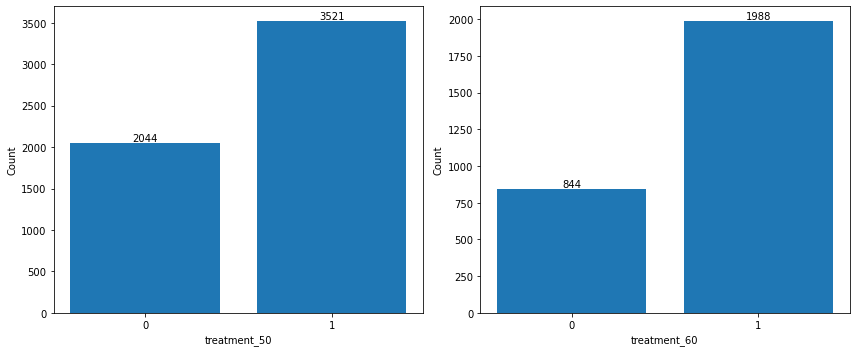

In [5]:
# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for df_50
counts50 = df50['treatment_50'].value_counts().sort_index()
axes[0].bar(counts50.index, counts50.values)
axes[0].set_xlabel('treatment_50')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])

# Annotating the bars with their counts for df50
for i in counts50.index:
    axes[0].text(i, counts50[i], str(counts50[i]), ha = 'center', va = 'bottom')

# Plot for df_60
counts60 = df60['treatment_60'].value_counts().sort_index()
axes[1].bar(counts60.index, counts60.values)
axes[1].set_xlabel('treatment_60')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])

# Annotating the bars with their counts for df60
for i in counts60.index:
    axes[1].text(i, counts60[i], str(counts60[i]), ha = 'center', va = 'bottom')

plt.tight_layout()
plt.show()

큰 문제없어 보인다. 데이터 양도 적당하고 밸런스도 좋아보인다.

# 2. 통제 변수 X와 Y 찾기

Linear Regression과 Causal Forest를 위해 통제변수 X와 Y를 살펴본다. (파일럿 분석인지라 X와 Y의 선정 둘 다 다소 간헐적임은 감안해주시길 바랍니다)

일단 X를 살펴봅니다.
- 건강: B1 (1->5 안 좋아짐)*(비해당:9)*
- 성별: RES_SEX <남자: 1, 여자: 2>
- 교육수준: RES_EDU1 <1->7 높아짐>
- 지역: (동부/읍면부) EDM <1:동부, 2:읍면부>
- 본인 총수입액 금액: J3b_1_13 
- 나이(?!): RES_AGE
- 인지기능: I1x1 *(결측치:99)*

필요한 데이터 클렌징을 실시해준다.

In [6]:
df = df[df['B1'] != 9]
df = df[df['I1x1'] != 99] 
df['RES_SEX'] = df['RES_SEX'].replace(2, 0)
df['EDM'] = df['EDM'].replace(2, 0)

그 다음 Y를 살펴본다
- 부동산자산비중
- 금융자산비중
- 문화여가비비중

부동산 자산: (보유주택, 전세/사무실보증금, 논, 밭, 임야 등)

금융자산: (저축, 타지 않은 곗돈 불입금액, 주식/채권 구입비용 등)

기타자산: (자동차, 농기계, 동물/식물, 골프회원권, 자영업자 설 비 및 재고자산 등)
- J6a_1 부동산자산_유무 (1 있음 2 없음)
- J6b_1 부동산자산_금액 (999998 모름/무응답) (999999	비해당)
- J6a_2 금융자산_유무 (1 있음 2 없음)
- J6b_2 금융자산_금액 (999998 모름/무응답) (999999	비해당)
- J6a_3 기타자산_유무 
- J6b_3 기타자산_금액 <999998 모름/무응답 존재>
- J6a_4 부채_유무
- J6b_4 부채_금액

In [7]:
df = df[df['J6b_3'] != 999998]
df = df[df['J4'] != 999998]
df['total_asset'] = df['J6b_1'] + df['J6b_2'] + df['J6b_3']
df['total_equity'] = df['total_asset'] - df['J6b_4']
df = df[df['total_asset'] != 0] # 158 pruned
df['debt_ratio'] = df['J6b_4'] / df['total_asset']
df['property_equity_ratio'] = df['J6b_1'] / df['total_asset']
df['financial_equity_ratio'] = df['J6b_2'] / df['total_asset']
df['extra_equity_ratio'] = df['J6b_3'] / df['total_asset']
df['leisure_expense_ratio'] = df['J1b_3']/ df['J4']

정리하자면, X, T와 Y는 아래와 같다:

X:
- 건강: B1 (비해당:9)
- 성별: RES_SEX <남자: 1, 여자: 2>
- 교육수준: RES_EDU1 <1->7 높아짐>
- 지역: (동부/읍면부) EDM <1:동부, 2:읍면부>
- 본인 총수입액 금액: J3b_1_13
- 나이(?!): RES_AGE
- 인지기능: I1x1 (결측치:99)

T:
- IMF 외환위기 당시 정년/은퇴 vs IMF 외환위기 전에 은퇴함

Y: 
- 부동산자산비중: property_equity_ratio
- 금융자산비중: financial_equity_ratio
- 문화여가비비중: leisure_expense_ratio

일단 CI를 그려본다. 변인 통제가 안 되어있다는 점은 감안 할 필요가 있다.

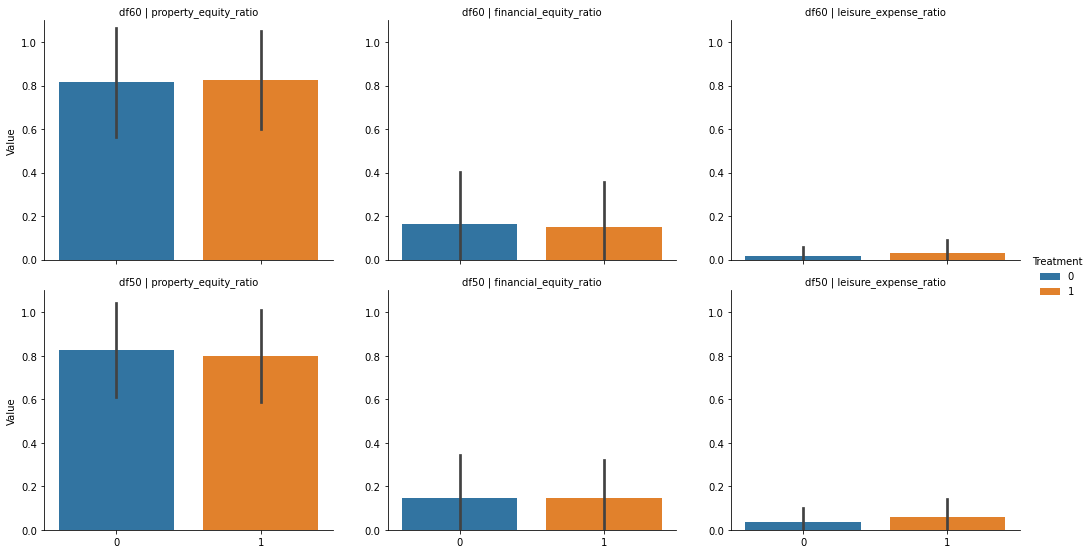

In [8]:
# Create df60 and df50 from the original dataframe df
df60 = df.query('treatment_60 != 2').copy() # Make a copy to avoid setting values on a slice warning
df50 = df.query('treatment_50 != 2').copy()

# Add dataset and treatment columns to both df60 and df50
df60['dataset'] = 'df60'
df60['treatment'] = df60['treatment_60']
df50['dataset'] = 'df50'
df50['treatment'] = df50['treatment_50']

# Combine the dataframes
combined_df = pd.concat([df60, df50], ignore_index=True)

# Melt the Combined DataFrame
melted_df = pd.melt(combined_df, id_vars=['treatment', 'dataset'], 
                    value_vars=['property_equity_ratio', 'financial_equity_ratio', 'leisure_expense_ratio'],
                    var_name='ratio_type', value_name='value')

# Create Subplots with Seaborn
g = sns.FacetGrid(melted_df, col="ratio_type", row="dataset", hue="treatment", height=4, aspect=1.2, sharey=False)
g.map(sns.barplot, 'treatment', 'value', order=[0, 1], ci='sd')
g.set_axis_labels("", "Value")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(ylim=(0, melted_df['value'].max() * 1.1))
g.add_legend(title="Treatment")
plt.show()


# 3. Linear Regression

그 다음으론 linear regression을 돌린다.

## 3.1 df60

Summary for dependent variable property_equity_ratio:
                              OLS Regression Results                             
Dep. Variable:     property_equity_ratio   R-squared:                       0.013
Model:                               OLS   Adj. R-squared:                  0.010
Method:                    Least Squares   F-statistic:                     3.592
Date:                   Tue, 08 Aug 2023   Prob (F-statistic):           0.000375
Time:                           13:57:35   Log-Likelihood:                 54.066
No. Observations:                   2116   AIC:                            -90.13
Df Residuals:                       2107   BIC:                            -39.22
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

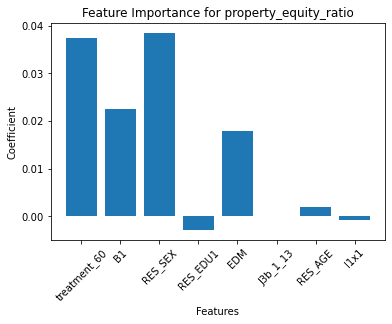

Summary for dependent variable financial_equity_ratio:
                              OLS Regression Results                              
Dep. Variable:     financial_equity_ratio   R-squared:                       0.012
Model:                                OLS   Adj. R-squared:                  0.008
Method:                     Least Squares   F-statistic:                     3.196
Date:                    Tue, 08 Aug 2023   Prob (F-statistic):            0.00130
Time:                            13:57:35   Log-Likelihood:                 187.96
No. Observations:                    2116   AIC:                            -357.9
Df Residuals:                        2107   BIC:                            -307.0
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

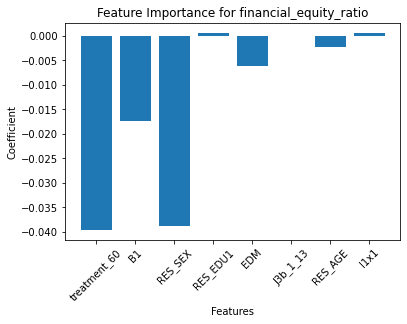

Summary for dependent variable leisure_expense_ratio:
                              OLS Regression Results                             
Dep. Variable:     leisure_expense_ratio   R-squared:                       0.132
Model:                               OLS   Adj. R-squared:                  0.128
Method:                    Least Squares   F-statistic:                     39.88
Date:                   Tue, 08 Aug 2023   Prob (F-statistic):           1.39e-59
Time:                           13:57:35   Log-Likelihood:                 3274.8
No. Observations:                   2116   AIC:                            -6532.
Df Residuals:                       2107   BIC:                            -6481.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

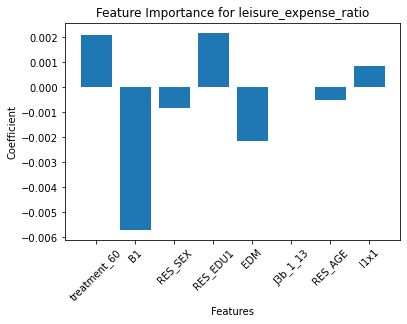

In [9]:
# Independent variables
X = df60[['treatment_60', 'B1', 'RES_SEX', 'RES_EDU1', 'EDM', 'J3b_1_13', 'RES_AGE', 'I1x1']]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# List of dependent variables
dependent_vars = ['property_equity_ratio', 'financial_equity_ratio', 'leisure_expense_ratio']

# Looping through the dependent variables
for var in dependent_vars:
    y = df60[var] # Selecting the dependent variable
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Creating an OLS model
    model = sm.OLS(y_train, X_train)

    # Fitting the model with the training data
    results = model.fit()

    # Printing the summary (including p-values)
    print(f'Summary for dependent variable {var}:')
    print(results.summary())

    # Plotting the feature importance
    plt.bar(X.columns[1:], results.params[1:]) # Excluding the constant
    plt.title(f'Feature Importance for {var}')
    plt.xlabel('Features')
    plt.ylabel('Coefficient')
    plt.xticks(rotation=45)
    plt.show()


R-squared 값을 보았을 때 결과는 아래와 같다:
- 부동산자산 비중: 0.013
- 금융자산 비중: 0.012
- 문화여가비 비중: 0.132.

자산 비중 예측의 효과는 영 좋지 않은듯 하다. 

문화여가비 예측은 그나마 괜찮다. 하지만 두가지 주의해야 할 사항이 있다:

- B1, 즉 건강상태와 관련이 가장 높다. B1값이 높을수록 건강이 안 좋음을 의미한다. 음의 상관관계를 지닌다는 것은, 건강이 좋을수록 여가비 지출이 늘어난다는 뜻으로 볼 수 있다. 혹은 건강상태가 안 좋을 수록 의료비 등 다른 곳의 지출이 늘어났을 수도 있다. 

- treatment_60은 1과 0, 두가지 값을 가진다. 1은 IMF 당시 정년임을 의미한다. 0은 IMF 당시 정년을 초과 했음을 의미한다. 비록 coefficient 자체가 높지는 않으나, 양수이다. IMF 당시 정년인 이들이 여가비 지출 성향이 더 두드러진다고 해석 할 수 있다. 우리의 가설과 반대된다. 앞서 말했듯, 평균 퇴직 연령이 50 정도였는데, 60이라는 숫자 선정이 잘못 된 것은 아닐까 의심해볼수 있다. 


## 3.2 df50

Summary for dependent variable property_equity_ratio:
                              OLS Regression Results                             
Dep. Variable:     property_equity_ratio   R-squared:                       0.024
Model:                               OLS   Adj. R-squared:                  0.022
Method:                    Least Squares   F-statistic:                     13.23
Date:                   Tue, 08 Aug 2023   Prob (F-statistic):           4.88e-19
Time:                           13:57:36   Log-Likelihood:                 640.38
No. Observations:                   4320   AIC:                            -1263.
Df Residuals:                       4311   BIC:                            -1205.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

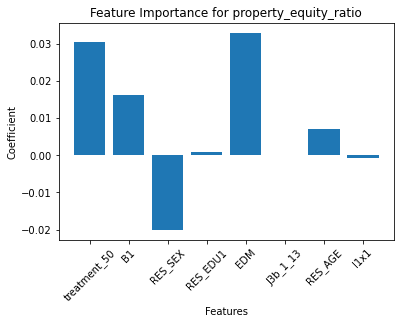

Summary for dependent variable financial_equity_ratio:
                              OLS Regression Results                              
Dep. Variable:     financial_equity_ratio   R-squared:                       0.004
Model:                                OLS   Adj. R-squared:                  0.002
Method:                     Least Squares   F-statistic:                     2.342
Date:                    Tue, 08 Aug 2023   Prob (F-statistic):             0.0165
Time:                            13:57:36   Log-Likelihood:                 1302.7
No. Observations:                    4320   AIC:                            -2587.
Df Residuals:                        4311   BIC:                            -2530.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

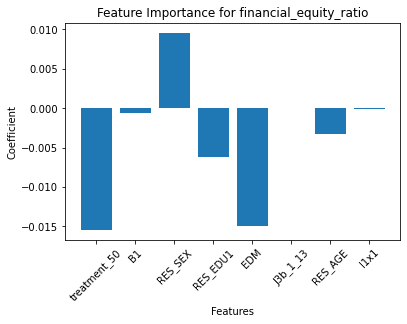

Summary for dependent variable leisure_expense_ratio:
                              OLS Regression Results                             
Dep. Variable:     leisure_expense_ratio   R-squared:                       0.108
Model:                               OLS   Adj. R-squared:                  0.106
Method:                    Least Squares   F-statistic:                     65.05
Date:                   Tue, 08 Aug 2023   Prob (F-statistic):          4.33e-101
Time:                           13:57:36   Log-Likelihood:                 5045.9
No. Observations:                   4320   AIC:                        -1.007e+04
Df Residuals:                       4311   BIC:                        -1.002e+04
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

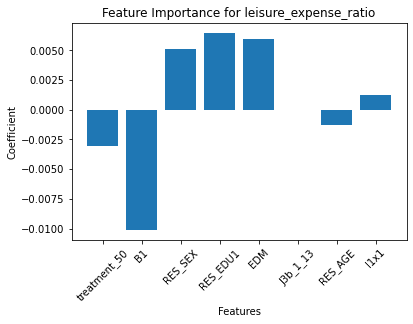

In [10]:
# Independent variables
X = df50[['treatment_50', 'B1', 'RES_SEX', 'RES_EDU1', 'EDM', 'J3b_1_13', 'RES_AGE', 'I1x1']]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# List of dependent variables
dependent_vars = ['property_equity_ratio', 'financial_equity_ratio', 'leisure_expense_ratio']

# Looping through the dependent variables
for var in dependent_vars:
    y = df50[var] # Selecting the dependent variable
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Creating an OLS model
    model = sm.OLS(y_train, X_train)

    # Fitting the model with the training data
    results = model.fit()

    # Printing the summary (including p-values)
    print(f'Summary for dependent variable {var}:')
    print(results.summary())

    # Plotting the feature importance
    plt.bar(X.columns[1:], results.params[1:]) # Excluding the constant
    plt.title(f'Feature Importance for {var}')
    plt.xlabel('Features')
    plt.ylabel('Coefficient')
    plt.xticks(rotation=45)
    plt.show()


기준을 50으로 잡았을 때의 양상 역시 비슷하다. 자산 비중에 대한 설명력은 없다시피 하지만, 문화여가비에 대한 설명력은 상대적으로 그나마 낫다. 


다만 주의할 점이, 여기서는 treatment_50의 coefficient가 음수를 띤다는 것이다. 즉, 트라우마를 겪은 집단의 문화여가비 소비성향이 낮다는 것이다. 

#### 그렇다면 60보단 50을 분기점으로 보는 것이 좋지 않을까 생각해볼 수 있다.

다만 문제가 몇가지 있다:
- 첫째로, 단순 노이즈 덕에 이런 결과가 나온 것일까? 그럼 두가지 방식으로 validate 할 수 있을 것이다.
    - 첫째, 통계적인 유의미성을 본다. 이는 앞서 계산한 수치를 보면 될텐데, 교수님들께서 판단을 해보시면 좋을 것 같다.
    - 둘째, 다른 샘플을 가져가본다. 랜덤하게 추출해보고 동일한 추세가 나오는지 확인해보는 것이다. 
- 둘째로, 분기점이 50세일지, 60세일지, 아님 다른 숫자를 가져가야 하는지, 그 숫자는 또 어떻게 판단해야하는지, 면밀히 검토해 볼 필요가 있다. 
    - 우리는 IMF의 트라우마를 겪은 사람들이 소비 관련해서 더 보수적일 것이라는 가설을 세웠다. 50을 분기점으로 두었을 때 우리 가설과 일치한 결과가 나왔고, 60을 분기점으로 두었을 때 우리 가설과 반대되는 결과가 나왔다. 그래서 50이 60보다 낫다는 판단을 한다. 이건 앞뒤가 바뀐 것이다. 분기점은 원인에 관한 것이고, 소비 성향은 그 결과이다. 결과로 원인을 판단하는 것은 앞뒤가 뒤집혔다. 심지어 "IMF의 트라우마를 겪은 사람들이 소비 관련해서 더 보수적일 것이라는 가설" 자체가 틀려먹었을 수도 있다. 그럼 60이 맞은 분기점인데도 불구하고 우리는 완전히 다른 결론에 다다를 수 있는 것이다.
    - 문제는, 우리가 각각의 개인이 언제 퇴직했는지에 대한 데이터가 없다는 것이다. 이 데이터 없이 연구를 지속하는 것이 가능한가 의구심이 든다. 박교수님께서 이렇게 long-term effect를 구하는 논문을 봤다고 하셨는데, 그런 논문들의 사례를 참고해보면 좋을 것 같다.
    
- 셋째로, 보다시피 건강에 대한 feature importance가 가장 높다. 
    - 고로, 이서현 교수님이 말씀하신대로 같은 해의 설문조사결과 대신 다른 두 해의 설문조사 결과를 파악하는 것도 나쁘지 않아보인다. 

# 3.3 Robustness Check

그래서, 아래와 같은 방식으로 coefficient에 대한 robustness check을 돌려봤다.
- linear regression을 100번 돌린다. 매번 마다 총 샘플에서 랜덤한 50%의 데이터를 뽑아서 돌려본다. 
- 각 regression마다 각 feature의 feature importance를 기록한다. 
- linear regression을 100번 다 돌린 후 feature importance의 결과를 확인한다. 

이러한 절차를 df60, df50, 두가지에 전부 적용해보았습니다.

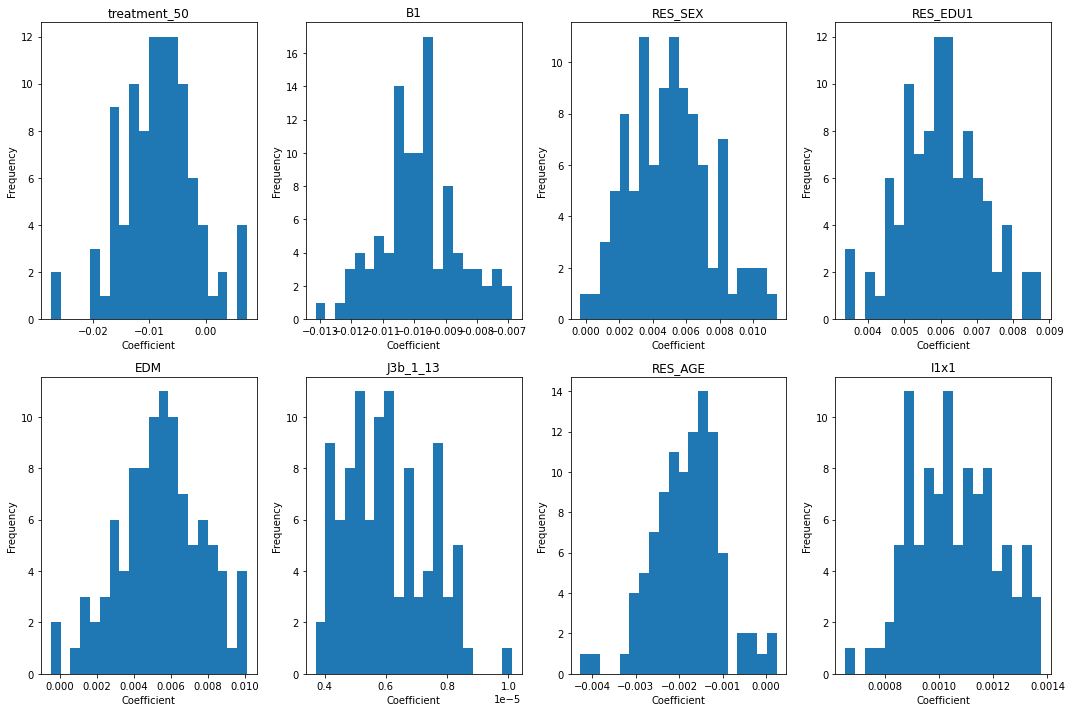

In [11]:
# Features and Target
X = df60[['treatment_50', 'B1', 'RES_SEX', 'RES_EDU1', 'EDM', 'J3b_1_13', 'RES_AGE', 'I1x1']]
Y = df60['leisure_expense_ratio']

# Initialize arrays to hold coefficients
coefs = {col: [] for col in X.columns}

# Run 100 linear regressions
for _ in range(100):
    # Take a random subsample of 0.3 of the entire dataset
    subsample = df50.sample(frac=0.5)
    X_subsample = subsample[['treatment_50', 'B1', 'RES_SEX', 'RES_EDU1', 'EDM', 'J3b_1_13', 'RES_AGE', 'I1x1']]
    Y_subsample = subsample['leisure_expense_ratio']

    # Fit linear regression
    model = LinearRegression()
    model.fit(X_subsample, Y_subsample)

    # Record coefficients
    for col, coef in zip(X.columns, model.coef_):
        coefs[col].append(coef)

# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(15, 10))

for idx, (feature, values) in enumerate(coefs.items()):
    row = idx // 4
    col = idx % 4
    axs[row, col].hist(values, bins=20)
    axs[row, col].set_title(f"{feature}")
    axs[row, col].set_xlabel("Coefficient")
    axs[row, col].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


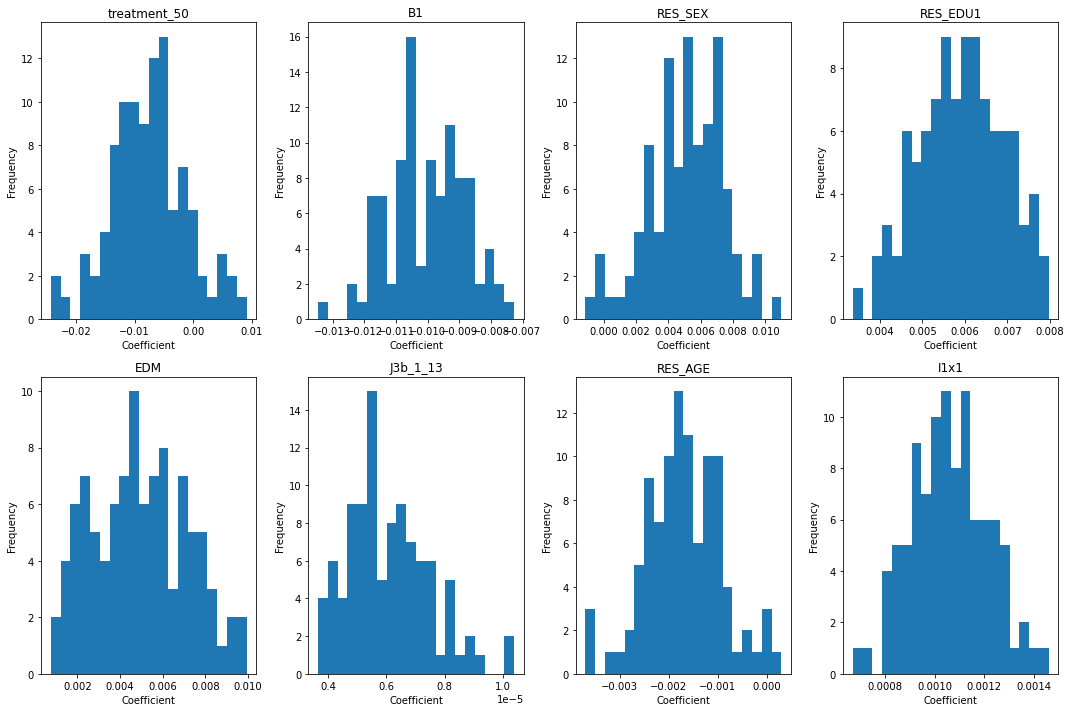

In [12]:
# Features and Target
X = df50[['treatment_50', 'B1', 'RES_SEX', 'RES_EDU1', 'EDM', 'J3b_1_13', 'RES_AGE', 'I1x1']]
Y = df50['leisure_expense_ratio']

# Initialize arrays to hold coefficients
coefs = {col: [] for col in X.columns}

# Run 100 linear regressions
for _ in range(100):
    # Take a random subsample of 0.3 of the entire dataset
    subsample = df50.sample(frac=0.5)
    X_subsample = subsample[['treatment_50', 'B1', 'RES_SEX', 'RES_EDU1', 'EDM', 'J3b_1_13', 'RES_AGE', 'I1x1']]
    Y_subsample = subsample['leisure_expense_ratio']

    # Fit linear regression
    model = LinearRegression()
    model.fit(X_subsample, Y_subsample)

    # Record coefficients
    for col, coef in zip(X.columns, model.coef_):
        coefs[col].append(coef)

# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(15, 10))

for idx, (feature, values) in enumerate(coefs.items()):
    row = idx // 4
    col = idx % 4
    axs[row, col].hist(values, bins=20)
    axs[row, col].set_title(f"{feature}")
    axs[row, col].set_xlabel("Coefficient")
    axs[row, col].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


df60과 df50 이 두가지 모두 treatment의 feature importance가 0에 가까운 수준에서 분포되어 퍼진 것 같다. 통계적인 유의미성이 있는지 모르겠다.

# 4.  Causal Forest

Linear Regression으론 잘 잡히지 않았다. 고로 이번에는 Causal Forest를 확인해본다.

Observational data를 잘 처리하는 CausalForestDML을 사용한다. DML, 즉 double machine learning의 수식은 아래와 같다:

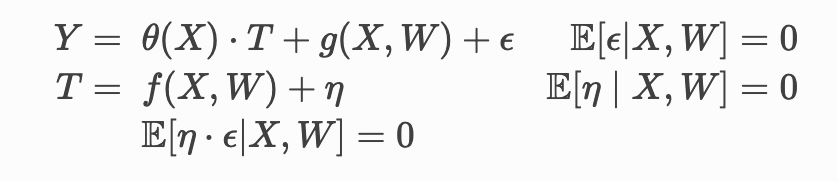

In [13]:
from IPython.display import Image
Image(filename='images/dml.png')

Y는 outcome이고 T는 treatment이다.

X와 W를 집고 넘어가야한다:
- T는 X와 W 두 값에 대해 고루 영향을 받는다.
- Y중 g, 즉 처치효과를 제외한 부분의 값은 X와 W 두 값에 대해 결과값을 얻는다. 
- theta, 즉 이질적 treatment effect는 X에 대해서만 영향을 받는다. 

즉, X는 heterogeneity를 야기하는 feature들이고, W는 이를 제외한 모든 control feature들의 값이다.

Causal forest는 처치효과의 이질성을 구하기 위한 기법이다. 하지만 그 전에 처치효과 자체를 정교하게 구해주기도 한다. 그래서 일단 causal forest를 돌려 처치효과와 이질적 처치효과를 모두 확인해본다. 

# 4.1 df60

In [14]:
X = df60[['B1', 'RES_SEX', 'RES_EDU1', 'EDM', 'J3b_1_13', 'RES_AGE', 'I1x1']]
Y = df60['leisure_expense_ratio'].values
T = df60['treatment_60'].values

# Define some parameters
n_trees = 1000
min_leaf_size = 10
max_depth = 20
subsample_ratio = 0.2

est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3),
                       model_t=WeightedLassoCVWrapper(cv=3),
                       n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                       max_samples=subsample_ratio/2,
                       random_state=123)
est.fit(Y, T, X=X)
treatment_effects = est.effect(X)
te_lower, te_upper = est.effect_interval(X)
shap_values = est.shap_values(X)

100%|===================| 2644/2645 [01:24<00:00]        

In [ ]:
# import joblib
# filename = 'causalforest_df60.sav'
# joblib.dump(est, filename)
# est = joblib.load(filename)

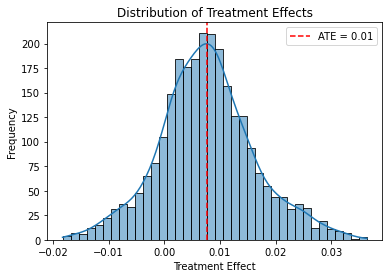

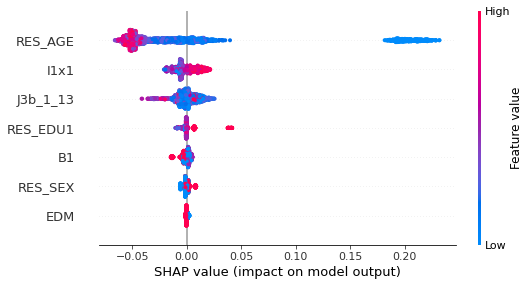

In [34]:
# Calculate the Average Treatment Effect (ATE)
ate = np.mean(treatment_effects)

# Plotting the distribution of treatment effects
sns.histplot(treatment_effects, kde=True)
plt.axvline(x=ate, color='r', linestyle='--', label=f'ATE = {ate:.2f}') # Add vertical line at ATE
plt.title('Distribution of Treatment Effects')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.legend() # Add legend to show the label for the ATE line
plt.show()

# Beeswarm Plot
shap.plots.beeswarm(shap_values['Y0']['T0'])

# # Waterfall Plot for the first instance
# instance_index = 0 # You can change this to any valid index in your dataset
# shap.plots.waterfall(shap_values['Y0']['T0'][instance_index])

# # Force Plot for the first instance
# shap.initjs() # Required for rendering force plot in Jupyter Notebook
# shap.plots.force(shap_values['Y0']['T0'][instance_index])

https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

1. TE in general:
- ATE가 양수이다. 즉, IMF 외환위기 당시 정리해고 당한 사람이 그렇지 않은 사람들보다 문화여가비 지출에 더 크다는 것을 의미한다. 우리의 가설과 반대된다.
- 애초에 Treatment effect가 상당히 작다. 사실 그냥 노이즈일 가능성이 높다. 그럼에도 불구하고 heterogeneity까지 살펴보았다.

2. Heterogeneity of TE:
- 나이의 영향이 제일 높음을 볼 수가 있다. 그 다음이 인지기능, 그 다음이 총수입액이다.
- 사실 우리가 답하는 문제가 무엇이냐에 따라 갈리겠지만, 이 결과대로라면 아래와 같은 결론을 도출할 수 있다: *IMF 때 정년 퇴직이 소비성향에 미치는 정도의 차이는 나이/인지기능/총수입액 에 따라 갈린다*. 

근본적인 문제는 아무래도 treatment effect가 너무 작다는 것에 있다. 

동일한 코드를 df50에 적용해보았다

In [31]:
X = df50[['B1', 'RES_SEX', 'RES_EDU1', 'EDM', 'J3b_1_13', 'RES_AGE', 'I1x1']]
Y = df50['leisure_expense_ratio'].values
T = df50['treatment_50'].values

# Define some parameters
n_trees = 1000
min_leaf_size = 10
max_depth = 20
subsample_ratio = 0.2

est2 = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3),
                       model_t=WeightedLassoCVWrapper(cv=3),
                       n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                       max_samples=subsample_ratio/2,
                       random_state=123)
est2.fit(Y, T, X=X)
treatment_effects2 = est.effect(X)
te_lower2, te_upper2 = est.effect_interval(X)
shap_values2 = est.shap_values(X)

 99%|===================| 5367/5400 [01:58<00:00]        

In [ ]:
# import joblib
# filename = 'causalforest_df50.sav'
# joblib.dump(est2, filename)
# est2 = joblib.load(filename)

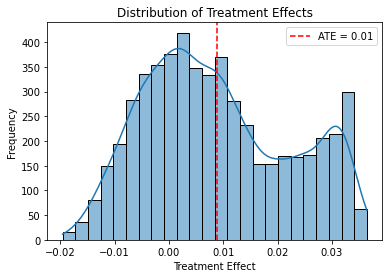

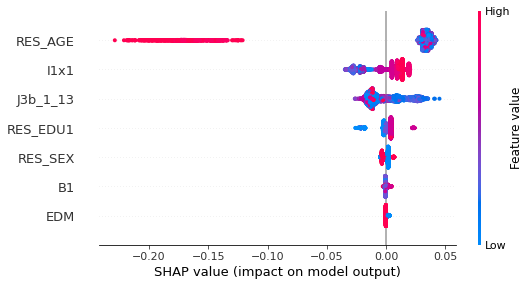

In [33]:
# Calculate the Average Treatment Effect (ATE)
ate = np.mean(treatment_effects2)

# Plotting the distribution of treatment effects
sns.histplot(treatment_effects2, kde=True)
plt.axvline(x=ate, color='r', linestyle='--', label=f'ATE = {ate:.2f}') # Add vertical line at ATE
plt.title('Distribution of Treatment Effects')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.legend() # Add legend to show the label for the ATE line
plt.show()

# Beeswarm Plot
shap.plots.beeswarm(shap_values2['Y0']['T0'])

# # Waterfall Plot for the first instance
# instance_index = 0 # You can change this to any valid index in your dataset
# shap.plots.waterfall(shap_values2['Y0']['T0'][instance_index])

# # Force Plot for the first instance
# shap.initjs() # Required for rendering force plot in Jupyter Notebook
# shap.plots.force(shap_values2['Y0']['T0'][instance_index])

1. TE in general:
- df50의 경우 분포의 모양이 조금 특이하다. 무언가 있을지도 모르겠다 싶기도 하지만, 애초에 TE의 값 자체가 적은 것은 변함이 없다. 

2. Heterogeneity:
- 나이, 인지기능, 소득, 교육 순으로 feature importance가 내려간다. 크게 바뀐 부분은 없다.